# Assemble the Features

We want to assemble our data in to a data frame of features; for now I'm going to try to make something including:

* Position player performance data (~3 numbers)
* Position player position
* Team salary data
* Team performance for position (previous year)
* Team value lost for position (from previous year, using FAs)

We'll try doing it in stages

In [25]:
# Bring in packages and connect to database
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
from scipy.stats import zscore

# Set postgres username/password, and connection specifics
username = 'postgres'
password = 'S@ndw1ches'     # change this
host     = 'localhost'
port     = '5432'            # default port that postgres listens on
db_name  = 'mlb_fa_db'

engine = create_engine( 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host, port, db_name) )

In [26]:
# Make a quick querying function
def pullFullTable(table, engine):
    '''Quick little function for pulling a full table'''
    
    query = 'select * from {}'.format(table)
    
    # Execute the query with context manager
    with engine.connect() as con:
        results = con.execute(query)
        fetched_data = pd.DataFrame(results.fetchall())
        fetched_data.columns = results.keys()
        
    return fetched_data

## Task 1: Grab Batting data and filter it by only free agents

We'll do it in 5 stages:

1. Pull batting data and shorten its columns to just the ones I want
2. Pull the "people" data to get the first/last names for batting data
3. Join batting and people to get all the data JUST for our desired years
3. Pull the "free_agents" data
5. Join "batting" and new free_agents/people to filter batting by only free agents

In [27]:
print(engine.table_names())

['batting', 'pitching', 'salary', 'people', 'appearances', 'teams', 'position_team_war', 'pitcher_team_war', 'payrolls', 'free_agents']


In [28]:
# Create our query
batting_data = pullFullTable('batting', engine)
    
batting_data.head()

,index,playerID,yearID,stint,teamID,lgID,G,AB,R,H,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,76643,abbotje01,1998,1,CHA,AL,89,244,33,68,...,41.0,3.0,3.0,9,28.0,1.0,0.0,2.0,5.0,2.0
1,76644,abbotji01,1998,1,CHA,AL,5,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,76645,abbotku01,1998,1,OAK,AL,35,123,17,33,...,9.0,2.0,1.0,10,34.0,0.0,1.0,1.0,1.0,3.0
3,76646,abbotku01,1998,2,COL,NL,42,71,9,18,...,15.0,0.0,0.0,2,19.0,0.0,1.0,0.0,2.0,2.0
4,76647,abbotpa01,1998,1,SEA,AL,4,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Drop non-numeric team/league columns
batting_data.drop(['teamID','lgID'], axis = 1)

# Add data from players who had multiple stints and 
batting_totals = batting_data.groupby(['playerID','yearID'], as_index= False).sum()

In [30]:
# Create new variables and select only them (fill NaN with 0)
batting_totals['OBP'] = (batting_totals['H'] + 
                       batting_totals['BB'] + 
                       batting_totals['HBP']).divide(batting_totals['AB'] + 
                                                   batting_totals['BB'] + 
                                                   batting_totals['HBP'] + 
                                                   batting_totals['SF']).fillna(0)

batting_totals['SLG'] = (batting_totals['H'] + 
                         batting_totals['2B'] + 
                         2 * batting_totals['3B'] + 
                         3 * batting_totals['HR']).divide(batting_totals['AB']).fillna(0)

batting_trimmed = batting_totals[['playerID', 'yearID', 'G', 'OBP', 'SLG', 'HR', 'RBI']]

# Fill "NaN" values for OBP/SLG with 0
print(batting_trimmed.shape)
print(batting_trimmed.head())
print(batting_trimmed[batting_trimmed['playerID'] == 'pujolal01'])

(25365, 7)
    playerID  yearID   G  OBP  SLG  HR  RBI
0  aardsda01    2004  11  0.0  0.0   0  0.0
1  aardsda01    2006  45  0.0  0.0   0  0.0
2  aardsda01    2007  25  0.0  0.0   0  0.0
3  aardsda01    2008  47  0.0  0.0   0  0.0
4  aardsda01    2009  73  0.0  0.0   0  0.0
        playerID  yearID    G       OBP       SLG  HR    RBI
18417  pujolal01    2001  161  0.402963  0.610169  37  130.0
18418  pujolal01    2002  157  0.394074  0.561017  34  127.0
18419  pujolal01    2003  157  0.439416  0.666667  43  124.0
18420  pujolal01    2004  154  0.414740  0.657095  46  123.0
18421  pujolal01    2005  161  0.430000  0.609137  41  117.0
18422  pujolal01    2006  143  0.430599  0.671028  49  137.0
18423  pujolal01    2007  158  0.428571  0.568142  32  103.0
18424  pujolal01    2008  148  0.461778  0.652672  37  116.0
18425  pujolal01    2009  160  0.442857  0.658451  47  135.0
18426  pujolal01    2010  159  0.414286  0.596252  42  118.0
18427  pujolal01    2011  147  0.365591  0.540587  37 

In [31]:
# Standardize the numerical columns by year
numerical = ['G', 'OBP', 'SLG', 'HR', 'RBI']

batting_trimmed[numerical] = batting_trimmed.groupby('yearID')[numerical].transform(zscore)

# Take a look at the output
print(batting_trimmed.shape)
print(batting_trimmed.head())
print(batting_trimmed[batting_trimmed['playerID'] == 'pujolal01'])

(25365, 7)
    playerID  yearID         G       OBP       SLG        HR       RBI
0  aardsda01    2004 -0.926802 -1.128818 -1.021286 -0.520478 -0.613383
1  aardsda01    2006 -0.223818 -1.096651 -1.018416 -0.510545 -0.606120
2  aardsda01    2007 -0.623055 -1.074030 -0.948662 -0.505253 -0.600185
3  aardsda01    2008 -0.146466 -1.085320 -0.912276 -0.496440 -0.599853
4  aardsda01    2009  0.388188 -1.070321 -1.006028 -0.506939 -0.601370
        playerID  yearID         G       OBP       SLG        HR       RBI
18417  pujolal01    2001  2.193543  1.141557  1.615230  3.637957  3.709145
18418  pujolal01    2002  2.089353  1.156760  1.559438  3.652412  3.852653
18419  pujolal01    2003  2.102354  1.271069  1.857574  4.707794  3.641002
18420  pujolal01    2004  2.069087  1.336778  1.943523  4.956622  3.615371
18421  pujolal01    2005  2.189724  1.362913  1.529887  4.658596  3.554547
18422  pujolal01    2006  1.802831  1.322061  1.937764  5.258251  3.979439
18423  pujolal01    2007  2.149787  1.

/home/matt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


### Now we'll pull the People and Free Agents and join People to Batting, and 

Note: I tried to do the join directly with SQL and it got mad, so I'm going to do it here instead

In [32]:
# Bring in people and free agents
people = pullFullTable('people', engine)
free_agents = pullFullTable('free_agents', engine)

print(people.shape, free_agents.shape)
print(people.columns, free_agents.columns)

(19370, 25) (1794, 14)
Index(['index', 'playerID', 'birthYear', 'birthMonth', 'birthDay',
       'birthCountry', 'birthState', 'birthCity', 'deathYear', 'deathMonth',
       'deathDay', 'deathCountry', 'deathState', 'deathCity', 'nameFirst',
       'nameLast', 'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut',
       'finalGame', 'retroID', 'bbrefID'],
      dtype='object') Index(['index', 'Unnamed: 0', 'Age', 'Destination', 'Full_Name', 'Origin',
       'WAR_3', 'nameFirst', 'nameLast', 'Year', 'Dollars', 'Length', 'Name',
       'Position'],
      dtype='object')


In [33]:
# Join people to batting, adding ONLY nameLast/nameFirst
people_trimmed = people[['playerID', 'nameFirst', 'nameLast']]

batting_w_people = pd.merge(batting_trimmed, people_trimmed, on = 'playerID', how = 'inner')
print(batting_w_people.shape)
print(batting_w_people.columns)

(25365, 9)
Index(['playerID', 'yearID', 'G', 'OBP', 'SLG', 'HR', 'RBI', 'nameFirst',
       'nameLast'],
      dtype='object')


In [34]:
free_agents.head(10)

,index,Unnamed: 0,Age,Destination,Full_Name,Origin,WAR_3,nameFirst,nameLast,Year,Dollars,Length,Name,Position
0,0,0,30,Texas Rangers,Bruce Chen,BAL,3.3,Bruce,Chen,2006,NaN,0,Bruce Chen,SP
1,1,1,34,Oakland Athletics,Todd Walker,SDP,3.1,Todd,Walker,2006,NaN,0,Todd Walker,1B
2,2,2,33,New York Mets,Ricky Ledee,NYM,1.8,Ricky,Ledee,2006,NaN,0,Ricky Ledee,LF
3,3,3,33,Los Angeles Dodgers,Tomas Perez,TBR,-1.1,Tomas,Perez,2006,NaN,0,Tomas Perez,2B
4,4,4,32,Washington Nationals,Ronnie Belliard,STL,9.6,Ronnie,Belliard,2006,NaN,0,Ronnie Belliard,2B
5,5,5,32,New York Mets,Fernando Tatis,BAL,0.1,Fernando,Tatis,2006,NaN,0,Fernando Tatis,1B
6,6,6,36,Baltimore Orioles,Steve Trachsel,NYM,4.0,Steve,Trachsel,2006,3100000.0,1,Steve Trachsel,SP
7,7,7,33,Atlanta Braves,Mark Redman,KCR,2.2,Mark,Redman,2006,NaN,0,Mark Redman,SP
8,8,8,41,New York Mets,Sandy Alomar,CHW,-0.4,Sandy,Alomar,2006,NaN,0,Sandy Alomar Jr.,C
9,9,9,34,Cincinnati Reds,Dustin Hermanson,CHW,3.3,Dustin,Hermanson,2006,NaN,0,Dustin Hermanson,RP


In [35]:
# Join based on nameFirst/nameLast
free_agents_batting = pd.merge(free_agents, batting_w_people, 
                               left_on = ['nameFirst', 'nameLast', 'Year'],
                               right_on = ['nameFirst', 'nameLast', 'yearID'])
print(free_agents_batting.shape)
print(free_agents_batting.columns)
print(free_agents_batting.head(10))

(1716, 21)
Index(['index', 'Unnamed: 0', 'Age', 'Destination', 'Full_Name', 'Origin',
       'WAR_3', 'nameFirst', 'nameLast', 'Year', 'Dollars', 'Length', 'Name',
       'Position', 'playerID', 'yearID', 'G', 'OBP', 'SLG', 'HR', 'RBI'],
      dtype='object')
   index  Unnamed: 0  Age           Destination         Full_Name Origin  \
0      0           0   30         Texas Rangers        Bruce Chen    BAL   
1      1           1   34     Oakland Athletics       Todd Walker    SDP   
2      2           2   33         New York Mets       Ricky Ledee    NYM   
3      3           3   33   Los Angeles Dodgers       Tomas Perez    TBR   
4      4           4   32  Washington Nationals   Ronnie Belliard    STL   
5      5           5   32         New York Mets    Fernando Tatis    BAL   
6      6           6   36     Baltimore Orioles    Steve Trachsel    NYM   
7      7           7   33        Atlanta Braves       Mark Redman    KCR   
8      8           8   41         New York Mets      San

In [36]:
# Pull out only the desired columns
free_agents_batting = free_agents_batting.drop(['index', 'Full_Name', 'Year'], axis = 1)
print(free_agents_batting.head(10))

   Unnamed: 0  Age           Destination Origin  WAR_3 nameFirst   nameLast  \
0           0   30         Texas Rangers    BAL    3.3     Bruce       Chen   
1           1   34     Oakland Athletics    SDP    3.1      Todd     Walker   
2           2   33         New York Mets    NYM    1.8     Ricky      Ledee   
3           3   33   Los Angeles Dodgers    TBR   -1.1     Tomas      Perez   
4           4   32  Washington Nationals    STL    9.6    Ronnie   Belliard   
5           5   32         New York Mets    BAL    0.1  Fernando      Tatis   
6           6   36     Baltimore Orioles    NYM    4.0     Steve   Trachsel   
7           7   33        Atlanta Braves    KCR    2.2      Mark     Redman   
8           8   41         New York Mets    CHW   -0.4     Sandy     Alomar   
9           9   34       Cincinnati Reds    CHW    3.3    Dustin  Hermanson   

     Dollars  Length              Name Position   playerID  yearID         G  \
0        NaN       0        Bruce Chen       SP   

## Task 2: Add positions

This will require data from our new "free_agents_batting" and "appearances". Basically:

* Pull appearances data
* Collapse "appearances" data into positions
* Join it with free_agents_batting data

In [37]:
# Bring in Appearances data to add positions
appearances = pullFullTable('appearances', engine)
    
print(appearances.head())

   index  yearID teamID lgID   playerID  G_all    GS  G_batting  G_defense  \
0  76591    1998    CHA   AL  abbotje01     89  61.0         89       76.0   
1  76592    1998    CHA   AL  abbotji01      5   5.0          0        5.0   
2  76593    1998    COL   NL  abbotku01     42  15.0         42       25.0   
3  76594    1998    OAK   AL  abbotku01     35  32.0         35       32.0   
4  76595    1998    SEA   AL  abbotpa01      4   4.0          0        4.0   

   G_p  ...   G_2b  G_3b  G_ss  G_lf  G_cf  G_rf  G_of  G_dh  G_ph  G_pr  
0    0  ...      0     0     0    20    38    27    76   2.0  15.0   0.0  
1    5  ...      0     0     0     0     0     0     0   0.0   0.0   0.0  
2    0  ...      7     3     7     4     0     5     9   1.0  19.0   1.0  
3    0  ...      0     1    28     5     0     1     5   3.0   1.0   1.0  
4    4  ...      0     0     0     0     0     0     0   0.0   0.0   0.0  

[5 rows x 22 columns]


In [38]:
# Subset to only positional data and group by playerID/yearID
appearances_compact = appearances.drop(['index', 'teamID','lgID', 'G_batting', 
                                        'G_defense','G_all','GS', 'G_ph', 'G_pr'], 
                                       axis = 1).groupby(['playerID','yearID'], 
                                                         as_index = False).sum()

# Check data
print(appearances_compact.head())

    playerID  yearID  G_p  G_c  G_1b  G_2b  G_3b  G_ss  G_lf  G_cf  G_rf  \
0  aardsda01    2004   11    0     0     0     0     0     0     0     0   
1  aardsda01    2006   45    0     0     0     0     0     0     0     0   
2  aardsda01    2007   25    0     0     0     0     0     0     0     0   
3  aardsda01    2008   47    0     0     0     0     0     0     0     0   
4  aardsda01    2009   73    0     0     0     0     0     0     0     0   

   G_of  G_dh  
0     0   0.0  
1     0   0.0  
2     0   0.0  
3     0   0.0  
4     0   0.0  


In [39]:
# Figure out primary position by melting, then grouping and finding the max value
appearances_melt = pd.melt(appearances_compact, id_vars= ['playerID', 'yearID'],
                           value_name = 'Games', var_name = 'Position')
print(appearances_melt[appearances_melt['playerID'] == 'clontbr01'])

         playerID  yearID Position  Games
4422    clontbr01    1998      G_p   20.0
4423    clontbr01    1999      G_p   56.0
4424    clontbr01    2000      G_p    5.0
29787   clontbr01    1998      G_c    0.0
29788   clontbr01    1999      G_c    0.0
29789   clontbr01    2000      G_c    0.0
55152   clontbr01    1998     G_1b    0.0
55153   clontbr01    1999     G_1b    0.0
55154   clontbr01    2000     G_1b    0.0
80517   clontbr01    1998     G_2b    0.0
80518   clontbr01    1999     G_2b    0.0
80519   clontbr01    2000     G_2b    0.0
105882  clontbr01    1998     G_3b    0.0
105883  clontbr01    1999     G_3b    0.0
105884  clontbr01    2000     G_3b    0.0
131247  clontbr01    1998     G_ss    0.0
131248  clontbr01    1999     G_ss    0.0
131249  clontbr01    2000     G_ss    0.0
156612  clontbr01    1998     G_lf    0.0
156613  clontbr01    1999     G_lf    0.0
156614  clontbr01    2000     G_lf    0.0
181977  clontbr01    1998     G_cf    0.0
181978  clontbr01    1999     G_cf

In [40]:
# Grab the index for the maximum games
primary_idx = appearances_melt.groupby(['playerID','yearID'])['Games'].idxmax()

# Use it to screen out the proper rows
primary_position = appearances_melt.loc[primary_idx]

# Turn the "Position" Column into the right contents by pulling just the position and capitalizing
primary_position['Position'] = primary_position.Position.str.split("_").str.get(1).str.upper()
print(primary_position[primary_position['playerID'] == 'clontbr01'])

       playerID  yearID Position  Games
4422  clontbr01    1998        P   20.0
4423  clontbr01    1999        P   56.0
4424  clontbr01    2000        P    5.0


In [41]:
# Do the join on the 6202 x 13 free_agents_batting
# Join based on nameFirst/nameLast
fa_bat_pos = pd.merge(free_agents_batting, primary_position, 
                      on = ['playerID', 'yearID']).drop(['Games'], axis = 1)
print(fa_bat_pos.head(10))
print(fa_bat_pos.shape)

   Unnamed: 0  Age           Destination Origin  WAR_3 nameFirst   nameLast  \
0           0   30         Texas Rangers    BAL    3.3     Bruce       Chen   
1           1   34     Oakland Athletics    SDP    3.1      Todd     Walker   
2           2   33         New York Mets    NYM    1.8     Ricky      Ledee   
3           3   33   Los Angeles Dodgers    TBR   -1.1     Tomas      Perez   
4           4   32  Washington Nationals    STL    9.6    Ronnie   Belliard   
5           5   32         New York Mets    BAL    0.1  Fernando      Tatis   
6           6   36     Baltimore Orioles    NYM    4.0     Steve   Trachsel   
7           7   33        Atlanta Braves    KCR    2.2      Mark     Redman   
8           8   41         New York Mets    CHW   -0.4     Sandy     Alomar   
9           9   34       Cincinnati Reds    CHW    3.3    Dustin  Hermanson   

     Dollars  Length              Name Position_x   playerID  yearID  \
0        NaN       0        Bruce Chen         SP   chenbr

## Task 3 Add Team WAR for position

Basically I see this as:

1. Load the Team WAR data
2. Change column names to be more concise
3. Join it to the existing data frame using yearID + position. This should necessarily remove pitchers

In [42]:
def allPositionWAR(fa_batting):
    
    # Pull the data but drop the index
    position_war = pullFullTable('position_team_war', engine).drop(['index'], axis = 1)
    
    # Change the Year to "yearID"
    position_war['yearID'] = position_war.Year
    position_war = position_war.drop(['Year'], axis = 1)
    
    # Create a dictionary for converting these to abbreviations
    team_dict = {'Angels' : 'LAA', 'Astros' : 'HOU', 'Athletics' : 'OAK', 'Blue Jays' : 'TOR', 
                 'Braves' : 'ATL', 'Brewers': 'MIL', 'Cardinals' : 'STL', 'Cubs' : 'CHN',
                 'Diamondbacks' : 'ARI', 'Dodgers' : 'LAN', 'Giants' : 'SFN', 'Indians' : 'CLE',
                 'Mariners' : 'SEA', 'Marlins' : 'MIA', 'Mets' : 'NYN', 'Nationals' : 'WAS',
                 'Orioles' : 'BAL', 'Padres' : 'SDN', 'Phillies' : 'PHI', 'Pirates' : 'PIT', 
                 'Rangers' : 'TEX', 'Rays' : 'TBR', 'Red Sox' : 'BOS', 'Reds' : 'CIN', 
                 'Rockies' : 'COL', 'Royals' : 'KCR', 'Tigers' : 'DET', 'Twins' : 'MIN', 
                 'White Sox' : 'CHA', 'Yankees' : 'NYA'}

    # Alter it to include WAR and Change the actual data frame
    team_dict = {key : value + "_WAR" for key, value in team_dict.items()}
    position_war = position_war.rename(columns = team_dict)
    
    # Merge the 2 data frames
    # This is only the ~2350 position players for now; do a left join
    fa_bat_team_war = pd.merge(fa_bat_pos, position_war, how = 'left',
                               on = ['Position', 'yearID'], )
    
    return fa_bat_team_war

### Now add these WAR data to the batting data, by position/year


# ALERT ALERT: Grab Pitcher info and add in to fix this!!

## Task ???: Pull Team data

Pull this to help with team -> teamID

In [43]:
# Change column names to team abbreviations using Team Data
teams = pullFullTable('teams', engine)
print(teams.head())
print(list(teams.columns))

   index  yearID lgID teamID franchID divID  Rank    G  Ghome    W  \
0   2265    1998   AL    ANA      ANA     W     2  162   81.0   85   
1   2266    1998   NL    ARI      ARI     W     5  162   81.0   65   
2   2267    1998   NL    ATL      ATL     E     1  162   81.0  106   
3   2268    1998   AL    BAL      BAL     E     4  162   81.0   79   
4   2269    1998   AL    BOS      BOS     E     2  162   81.0   92   

      ...        DP     FP                  name                         park  \
0     ...       146  0.983        Anaheim Angels   Edison International Field   
1     ...       125  0.984  Arizona Diamondbacks            Bank One Ballpark   
2     ...       139  0.985        Atlanta Braves                 Turner Field   
3     ...       144  0.987     Baltimore Orioles  Oriole Park at Camden Yards   
4     ...       128  0.983        Boston Red Sox               Fenway Park II   

  attendance  BPF  PPF  teamIDBR  teamIDlahman45  teamIDretro  
0  2519280.0  102  102      

In [44]:
# Pull just a handful of these columns (W, G, teamID, name, yearID)
teams_short = teams[['yearID', 'teamID', 'name', 'W', 'G']]
teams_short['teamID'].value_counts()

HOU    20
ARI    20
CHA    20
COL    20
KCA    20
SDN    20
BOS    20
OAK    20
TBA    20
PIT    20
CLE    20
TEX    20
SLN    20
TOR    20
CHN    20
MIN    20
NYA    20
ATL    20
DET    20
NYN    20
CIN    20
LAN    20
PHI    20
SEA    20
BAL    20
SFN    20
MIL    20
FLO    14
WAS    13
LAA    13
MON     7
ANA     7
MIA     6
Name: teamID, dtype: int64

In [45]:
# Convert altered names/teamID 
name_change = {'Anaheim Angels': 'Los Angeles Angels of Anaheim', 
                   'Tampa Bay Devil Rays' : 'Tampa Bay Rays',
                   'Montreal Expos' : 'Washington Nationals', 
                   'Florida Marlins' : 'Miami Marlins'
                  }
    
origin_change = {'ANA': 'LAA', 'TBD':'TBR', 'MON':'WAS', 'FLO':'MIA'}

teams_short['name'] = teams_short['name'].replace(name_change)
teams_short['teamID'] = teams_short['teamID'].replace(origin_change)

# Change W/G to W_Pct
    
teams_short['W_Pct'] = teams_short['W'].divide(teams_short.G)

teams_short = teams_short.drop(['W','G'], axis = 1)

teams_short.head()

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,yearID,teamID,name,W_Pct
0,1998,LAA,Los Angeles Angels of Anaheim,0.524691
1,1998,ARI,Arizona Diamondbacks,0.401235
2,1998,ATL,Atlanta Braves,0.654321
3,1998,BAL,Baltimore Orioles,0.487654
4,1998,BOS,Boston Red Sox,0.567901


In [46]:
teams_short.name.value_counts()

Cincinnati Reds                  20
Pittsburgh Pirates               20
Houston Astros                   20
Minnesota Twins                  20
Los Angeles Angels of Anaheim    20
Tampa Bay Rays                   20
Chicago White Sox                20
Texas Rangers                    20
Toronto Blue Jays                20
Chicago Cubs                     20
San Diego Padres                 20
Atlanta Braves                   20
Boston Red Sox                   20
Colorado Rockies                 20
Los Angeles Dodgers              20
Cleveland Indians                20
Milwaukee Brewers                20
Kansas City Royals               20
Philadelphia Phillies            20
Detroit Tigers                   20
Baltimore Orioles                20
Miami Marlins                    20
New York Mets                    20
Washington Nationals             20
New York Yankees                 20
Oakland Athletics                20
St. Louis Cardinals              20
Arizona Diamondbacks        

### Next task: Use these data to change the free_agents data a bit

We need to convert the Destination data from free_agents...this is where to do it!

*This will also remove the FAs without teams*

In [48]:
# Check destination data
fa_bat_pos.Destination.value_counts()

Los Angeles Dodgers              91
New York Mets                    80
New York Yankees                 77
Washington Nationals             76
Chicago Cubs                     73
Baltimore Orioles                69
Boston Red Sox                   67
Kansas City Royals               66
Toronto Blue Jays                64
Colorado Rockies                 63
Houston Astros                   60
Texas Rangers                    59
San Diego Padres                 58
Seattle Mariners                 56
Cleveland Indians                54
Philadelphia Phillies            53
Cincinnati Reds                  53
San Francisco Giants             53
Milwaukee Brewers                52
Chicago White Sox                51
Pittsburgh Pirates               50
Atlanta Braves                   50
St. Louis Cardinals              47
Tampa Bay Rays                   45
Arizona Diamondbacks             45
Detroit Tigers                   42
Minnesota Twins                  41
Miami Marlins               

In [51]:
#Fix the weird angels data
fa_bat_pos['Destination'] = fa_bat_pos['Destination'].replace({'Los Angeles Angels' :
                                                                         'Los Angeles Angels of Anaheim'})
fa_bat_pos.Destination.value_counts()

Los Angeles Dodgers              91
New York Mets                    80
New York Yankees                 77
Washington Nationals             76
Chicago Cubs                     73
Baltimore Orioles                69
Boston Red Sox                   67
Kansas City Royals               66
Toronto Blue Jays                64
Colorado Rockies                 63
Houston Astros                   60
Texas Rangers                    59
San Diego Padres                 58
Seattle Mariners                 56
Cleveland Indians                54
Philadelphia Phillies            53
Cincinnati Reds                  53
San Francisco Giants             53
Milwaukee Brewers                52
Chicago White Sox                51
Pittsburgh Pirates               50
Atlanta Braves                   50
St. Louis Cardinals              47
Tampa Bay Rays                   45
Arizona Diamondbacks             45
Detroit Tigers                   42
Minnesota Twins                  41
Miami Marlins               

In [52]:
# Do a join to the sub-team DF
team_translate = teams_short[['teamID', 'name']].drop_duplicates()


fa_bat_team_war_teamID = pd.merge(fa_bat_pos, team_translate, how = 'left',
                          left_on = ['Destination'], right_on = ['name'])

# Substitute the Destination Column with the info from teamID and drop teamID
fa_bat_team_war_teamID['Destination'] = fa_bat_team_war_teamID['teamID']
fa_bat_team_war_teamID = fa_bat_team_war_teamID.drop(['teamID'], axis = 1)
fa_bat_team_war_teamID.drop_duplicates().head(10)

,Unnamed: 0,Age,Destination,Origin,WAR_3,nameFirst,nameLast,Dollars,Length,Name,Position_x,playerID,yearID,G,OBP,SLG,HR,RBI,Position_y,name
0,0,30,TEX,BAL,3.3,Bruce,Chen,NaN,0,Bruce Chen,SP,chenbr01,2006,-0.327218,4.520430,3.387034,-0.510545,-0.606120,P,Texas Rangers
1,1,34,OAK,SDP,3.1,Todd,Walker,NaN,0,Todd Walker,1B,walketo04,2006,1.699431,0.902271,0.735790,0.549030,1.167855,2B,Oakland Athletics
2,2,33,NYN,NYM,1.8,Ricky,Ledee,NaN,0,Ricky Ledee,LF,ledeeri01,2006,0.293184,0.261325,0.432791,-0.275084,-0.304879,OF,New York Mets
3,3,33,LAN,TBR,-1.1,Tomas,Perez,NaN,0,Tomas Perez,2B,perezto03,2006,0.892907,0.161575,0.242895,-0.275084,-0.070581,3B,Los Angeles Dodgers
4,4,32,WAS,STL,9.6,Ronnie,Belliard,NaN,0,Ronnie Belliard,2B,belliro01,2006,1.885552,0.711915,0.755101,1.019952,1.636452,2B,Washington Nationals
5,5,32,NYN,BAL,0.1,Fernando,Tatis,NaN,0,Fernando Tatis,1B,tatisfe01,2006,-0.575380,0.658687,1.184309,-0.275084,-0.338351,DH,New York Mets
6,6,36,BAL,NYM,4.0,Steve,Trachsel,3100000.0,1,Steve Trachsel,SP,trachst01,2006,-0.534019,0.128894,-0.049217,-0.392814,-0.539178,P,Baltimore Orioles
7,7,33,ATL,KCR,2.2,Mark,Redman,NaN,0,Mark Redman,SP,redmama01,2006,-0.554699,1.711890,-1.018416,-0.510545,-0.606120,P,Atlanta Braves
8,8,41,NYN,CHW,-0.4,Sandy,Alomar,NaN,0,Sandy Alomar Jr.,C,alomasa02,2006,-0.203138,0.543736,0.654023,-0.392814,-0.037109,C,New York Mets
9,9,34,CIN,CHW,3.3,Dustin,Hermanson,NaN,0,Dustin Hermanson,RP,hermadu01,2006,-1.030342,-1.096651,-1.018416,-0.510545,-0.606120,P,Cincinnati Reds


## Task 5: Use payroll data to cluster teams

Now I need to use payroll data to create clusters of teams. So I'll:

1. Load the payroll data
2. Standardize it for each year
3. Run it through clustering
4. Use cluster labels to create a translation

In [53]:
# Load payroll data
payrolls = pullFullTable('payrolls', engine)
payrolls.set_index('Year', inplace=True)
payrolls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 1998 to 2017
Data columns (total 31 columns):
index                    20 non-null int64
Arizona Diamondbacks     20 non-null float64
Atlanta Braves           20 non-null float64
Baltimore Orioles        20 non-null float64
Boston Red Sox           20 non-null float64
Chicago Cubs             20 non-null float64
Chicago White Sox        20 non-null float64
Cincinnati Reds          20 non-null float64
Cleveland Indians        20 non-null float64
Colorado Rockies         20 non-null float64
Detroit Tigers           20 non-null float64
Houston Astros           20 non-null float64
Kansas City Royals       20 non-null float64
Los Angeles Angels       20 non-null float64
Los Angeles Dodgers      20 non-null float64
Miami Marlins            20 non-null float64
Milwaukee Brewers        20 non-null float64
Minnesota Twins          20 non-null float64
New York Mets            20 non-null float64
New York Yankees         20 non-null fl

In [54]:
# Transpose the data and standardize it
payrolls_transposed = payrolls.transpose()
payrolls_transposed_standard = payrolls_transposed.transform(zscore)
payrolls_transposed_standard

Year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
index,-2.401578,-2.040984,-2.266215,-2.287018,-2.325516,-2.160705,-1.813430,-1.820954,-2.006667,-2.017893,-1.959364,-2.111651,-1.933544,-1.843838,-2.106917,-1.871592,-2.105540,-2.339795,-2.182169,-2.345991
Arizona Diamondbacks,-0.608206,1.060551,1.011678,0.826592,1.414762,0.400880,0.082364,-0.245014,-0.466033,-0.796956,-0.528953,-0.351682,-0.701674,-0.874399,-0.544957,-0.278682,0.016595,-1.216173,-0.576313,-0.769150
Atlanta Braves,1.260197,1.270688,1.221190,1.079845,1.060870,1.267836,0.688733,0.442270,0.442607,0.201452,0.391651,0.301692,-0.102427,-0.078619,-0.310974,-0.297120,-0.022691,-0.666688,-0.851853,0.255478
Baltimore Orioles,1.928714,1.080671,1.238902,0.411318,-0.187403,0.171949,-0.457423,0.084814,-0.081173,0.368137,-0.503501,-0.532408,-0.173477,-0.119172,-0.359688,-0.244136,-0.099289,0.006979,0.404800,0.790544
Boston Red Sox,0.774953,1.120910,1.155529,1.751400,1.624826,1.054822,1.792086,1.497548,1.335150,1.781555,1.181177,1.006017,1.878122,1.704729,2.017973,1.179649,1.116840,1.155022,1.438473,1.067750
Chicago Cubs,0.635346,0.389900,0.331304,0.041849,0.387908,0.374803,0.700028,0.458505,0.569602,0.552397,0.798376,1.373663,1.476348,0.829037,-0.184266,0.017816,-0.503129,-0.032188,0.793025,0.975421
Chicago White Sox,-0.135878,-0.988063,-1.006550,0.083868,-0.317605,-0.602554,-0.053474,0.120987,0.817928,0.807527,0.870661,0.283112,0.500612,0.894398,0.041684,0.439993,-0.455941,-0.180791,-0.231092,-0.354550
Cincinnati Reds,-1.048554,-0.201613,-0.442379,-0.553996,-0.771798,-0.319777,-0.606043,-0.257547,-0.429365,-0.330635,-0.327372,-0.350556,-0.406602,-0.342209,-0.339736,0.153879,0.010011,-0.019056,-0.685613,-0.952708
Cleveland Indians,1.228831,1.216142,0.952496,1.107101,0.509783,-0.786444,-0.971647,-0.838306,-0.574843,-0.524817,-0.203929,-0.124788,-0.689538,-0.980551,-0.437424,-0.440601,-0.645351,-0.709771,-0.589254,-0.213859
Colorado Rockies,0.515419,0.346085,0.417700,0.307594,-0.325175,-0.054949,-0.046341,-0.648612,-1.016047,-0.741111,-0.466341,-0.304389,-0.107232,-0.051187,-0.446752,-0.590440,-0.353445,-0.467629,-0.286040,-0.532173


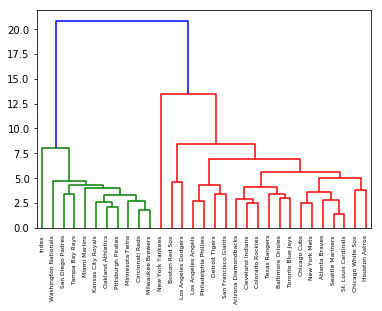

In [60]:
# Cluster them via hierarchical clustering

# Perform the necessary imports
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calculate the linkage: mergings
mergings = linkage(payrolls_transposed_standard.values, method = 'complete')

# Plot the dendrogram, using varieties as labels
dendrogram(mergings,
           labels=list(payrolls_transposed_standard.index),
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.savefig('./Payroll_Clustering')
plt.show()

In [56]:
# Select clusters using maximum height of 6
from scipy.cluster.hierarchy import fcluster

# Use fcluster to extract labels: labels
labels = fcluster(mergings, 6, criterion = 'distance')


label_data = pd.DataFrame({'label' : labels, 'Team' : list(payrolls_transposed_standard.index)})

label_data.sort_values('label')

,Team,label
15,Miami Marlins,1
27,Tampa Bay Rays,1
23,San Diego Padres,1
22,Pittsburgh Pirates,1
20,Oakland Athletics,1
17,Minnesota Twins,1
16,Milwaukee Brewers,1
12,Kansas City Royals,1
30,Washington Nationals,1
7,Cincinnati Reds,1


In [61]:
# Join this to the existing data
label_data['Team'] = label_data.replace({'Los Angeles Angels':
                                         'Los Angeles Angels of Anaheim'})

labels_as_teamID = pd.merge(label_data, team_translate, 
                            left_on = ['Team'], right_on = ['name'])[['teamID', 'label']]
fa_with_clusters = pd.merge(fa_bat_team_war_teamID, labels_as_teamID,
                            left_on = ['Destination'], right_on = ['teamID'])
fa_with_clusters.head()

,Unnamed: 0,Age,Destination,Origin,WAR_3,nameFirst,nameLast,Dollars,Length,Name,...,yearID,G,OBP,SLG,HR,RBI,Position_y,name,teamID,label
0,0,30,TEX,BAL,3.3,Bruce,Chen,NaN,0,Bruce Chen,...,2006,-0.327218,4.520430,3.387034,-0.510545,-0.606120,P,Texas Rangers,TEX,5
1,34,32,TEX,SFG,1.6,Jamey,Wright,NaN,0,Jamey Wright,...,2006,-0.430619,0.337498,0.293846,-0.510545,-0.572649,P,Texas Rangers,TEX,5
2,48,28,TEX,MIN,0.0,Willie,Eyre,NaN,0,Willie Eyre,...,2006,-0.285858,-1.096651,-1.018416,-0.510545,-0.606120,P,Texas Rangers,TEX,5
3,63,27,TEX,TEX,0.7,Mike,Wood,NaN,0,Mike Wood,...,2006,-0.678780,-1.096651,-1.018416,-0.510545,-0.606120,P,Texas Rangers,TEX,5
4,71,31,TEX,LAD,2.6,Eric,Gagne,6000000.0,1,Eric Gagne,...,2006,-1.113062,-1.096651,-1.018416,-0.510545,-0.606120,P,Texas Rangers,TEX,5


# Final Task: Save the data

For now, save a test set

In [64]:
import pickle

final_data = fa_with_clusters.dropna()

final_data.to_pickle('final_data.pickle')

# Experiments with Standardizing



## Some useful plots

Things I could plot:

* Player contract vs WAR
* Player contract vs Age